In [1]:
# Load xml-model to mujoco
from mujoco_py import load_model_from_path, MjSim, MjViewer
import matplotlib.pyplot as plt
import numpy as np
import math

from LegModel.legs import LegModel

RUN_STEPS = 100

model = load_model_from_path("../models/dynamic_4l_VerticalSpine.xml") # test.xml / dynamic_4l_VerticalSpine.xml
sim = MjSim(model)
# viewer = MjViewer(sim)
# sim_state = sim.get_state()
# sim.set_state(sim_state)

In [ ]:
# Test of the output of sim.model.body_inertia based on the a simple xml-file (../models/test.xml)
# The outputs is only based on the local frame and the COM of the corresponding body
# The 3 outputs of a certain body is the body inertia around [z, y, x] axis
# -> In my works, only the 3rd output around x-axis will be considered, because the 2d dynamic model is in y-z plane
bodymass = sim.model.body_inertia
# print(bodymass)
bodypos = sim.model.body_ipos
# print(bodypos)

In [3]:
# Run mujoco simulation for one timestep
# relevant for the computation of COM postion in world frame as the actuator can change the position of the bodys
# Initialization with all the actuators set to zeros
ctrlData = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0,0,0,0,0]
sim.data.ctrl[:] = ctrlData
sim.step()

In [ ]:
# Test of certain command
bodyInertia = sim.model.body_inertia
print(bodyInertia[:,-1])

In [ ]:
# Summarize all the important parameters of bodies to a dataframe-table
import pandas
bodyName = []
for i in range(sim.model.nbody):
    bodyName.append(sim.model.body_id2name(i))
    if bodyName[-1] == None:
        bodyName[-1] = 'None'
bodyMass = sim.model.body_mass
body_COM_pos = sim.data.xipos
df = pandas.DataFrame({"Body Name":bodyName, "Body Mass":bodyMass})
df['Body COM-based Inertia in x-axis'] = sim.model.body_inertia[:,-1]
df['Body COM Position'] = np.around(body_COM_pos, decimals=3).tolist()
# df

In [6]:
# Save the dataframe-table
df.to_excel("ModelBodyInfo.xlsx")

In [5]:
# calculated the key parameters based on dynamic model with rigid spine
body_COM_pos_y = body_COM_pos[:,1] # bodies pos in y-axis
body_COM_pos_z = body_COM_pos[:,2] # bodies pos in z-axis
body_mass = sum(bodyMass) # whole body mass
COM_y = sum(body_COM_pos_y*bodyMass) / sum(bodyMass) # whole body COM position in y-axis
COM_z = sum(body_COM_pos_z*bodyMass) / sum(bodyMass) # whole body COM position in z-axis

i_xx_i = sim.model.body_inertia[:,-1] # com-based bodies moment of inertia around x-axis
l_i_COM_quad = (body_COM_pos_y-COM_y)**2 + (body_COM_pos_z-COM_z)**2 # quadrat distance between each body COM pos and whole body COM pos
i_xx_sum = sum(i_xx_i) + sum(bodyMass*l_i_COM_quad) #com-based whole body moment of inertia around x-axis
print(i_xx_sum)

0.0014641083099278


In [ ]:
# COM pos of each subtree
np.around(sim.data.subtree_com, decimals=3)

In [6]:
# Summarize all the important parameters of sites to a dataframe-table
import pandas
siteName = []
for i in range(sim.model.nsite):
    siteName.append(sim.model.site_id2name(i))
    if siteName[-1] == None:
        siteName[-1] = 'None'
site_pos = sim.data.site_xpos
df2 = pandas.DataFrame({"Site Name":siteName})
df2['Site Position'] = np.around(site_pos, decimals=3).tolist()
# df2

In [168]:
# Save the dataframe-table
df2.to_excel("ModelSiteInfo.xlsx")

In [7]:
# Calculated the key lengths based on leg joints
legJoint_fl_siteIndex = np.array([siteName.index("thigh_link_fl"), siteName.index("leg_link_fl")]) # index of global pos of two fl leg joint
legJoint_fr_siteIndex = np.array([siteName.index("thigh_link_fr"), siteName.index("leg_link_fr")])
legJoint_rl_siteIndex = np.array([siteName.index("thigh_link_rl"), siteName.index("leg_link_rl")])
legJoint_rr_siteIndex = np.array([siteName.index("thigh_link_rr"), siteName.index("leg_link_rr")])
# print(legJoint_fl_siteIndex,"\n",legJoint_fr_siteIndex,"\n",legJoint_rl_siteIndex,"\n",legJoint_rr_siteIndex)
legJoint_fl = (site_pos[legJoint_fl_siteIndex[0]]+site_pos[legJoint_fl_siteIndex[1]]) / 2.0 # global pos of midpoint of two fl leg joint
legJoint_fr = (site_pos[legJoint_fr_siteIndex[0]]+site_pos[legJoint_fr_siteIndex[1]]) / 2.0
legJoint_rl = (site_pos[legJoint_rl_siteIndex[0]]+site_pos[legJoint_rl_siteIndex[1]]) / 2.0
legJoint_rr = (site_pos[legJoint_rr_siteIndex[0]]+site_pos[legJoint_rr_siteIndex[1]]) / 2.0
# print(legJoint_fl,"\n",legJoint_fr,"\n",legJoint_rl,"\n",legJoint_rr)
legJoint_fl_offset = (site_pos[legJoint_fl_siteIndex[0]]-site_pos[legJoint_fl_siteIndex[1]]) / 2.0 # fixed global pos offset between the midpoint of two fl leg joint and fl leg joint "leg_joint_fl"
legJoint_fr_offset = (site_pos[legJoint_fr_siteIndex[0]]-site_pos[legJoint_fr_siteIndex[1]]) / 2.0
legJoint_rl_offset = (site_pos[legJoint_rl_siteIndex[0]]-site_pos[legJoint_rl_siteIndex[1]]) / 2.0
legJoint_rr_offset = (site_pos[legJoint_rr_siteIndex[0]]-site_pos[legJoint_rr_siteIndex[1]]) / 2.0
# print(legJoint_fl_offset,"\n",legJoint_fr_offset,"\n",legJoint_rl_offset,"\n",legJoint_rr_offset)
l_f_COM = np.array([COM_y,COM_z])-legJoint_fl[1:3] # distance between front leg joint and whole body COM in y-z plane
l_r_COM = np.array([COM_y,COM_z])-legJoint_rl[1:3] # distance between rear leg joint and whole body COM in y-z plane
print(l_f_COM,l_r_COM)

[0.06928489 0.01211138] [-0.05690498 -0.01721967]


In [8]:
split_index = bodyName.index("v1")
split_index

26

In [10]:
body_mass_f = sum(bodyMass[0:split_index]) # front torso body mass
body_mass_r = sum(bodyMass[split_index:len(bodyMass)+1]) # rear torso body mass
COM_y_f = sum(body_COM_pos_y[0:split_index]*bodyMass[0:split_index]) / body_mass_f # front body COM position in y-axis
COM_z_f = sum(body_COM_pos_z[0:split_index]*bodyMass[0:split_index]) / body_mass_f # front body COM position in z-axis
COM_y_r = sum(body_COM_pos_y[split_index:len(bodyMass)+1]*bodyMass[split_index:len(bodyMass)+1]) / body_mass_r # front body COM position in y-axis
COM_z_r = sum(body_COM_pos_z[split_index:len(bodyMass)+1]*bodyMass[split_index:len(bodyMass)+1]) / body_mass_r # front body COM position in z-axis
print(COM_y_f,COM_z_f)
print(COM_y_r,COM_z_r)

0.028814376642772806 0.10198771617647803
0.1398077037751029 0.12813726404844528


In [12]:
# calculated the key parameters based on dynamic model with activ spine
split_index = bodyName.index("v1") # this index split bodies to the front/rear torso

body_mass_f = sum(bodyMass[0:split_index]) # front torso body mass
body_mass_r = sum(bodyMass[split_index:len(bodyMass)+1]) # rear torso body mass
COM_y_f = sum(body_COM_pos_y[0:split_index]*bodyMass[0:split_index]) / body_mass_f # front body COM position in y-axis
COM_z_f = sum(body_COM_pos_z[0:split_index]*bodyMass[0:split_index]) / body_mass_f # front body COM position in z-axis
COM_y_r = sum(body_COM_pos_y[split_index:len(bodyMass)+1]*bodyMass[split_index:len(bodyMass)+1]) / body_mass_r # rear body COM position in y-axis
COM_z_r = sum(body_COM_pos_z[split_index:len(bodyMass)+1]*bodyMass[split_index:len(bodyMass)+1]) / body_mass_r # rear body COM position in z-axis

i_xx_i = sim.model.body_inertia[:,-1] # com-based bodies moment of inertia around x-axis
l_i_COM_f_quad = (body_COM_pos_y-COM_y_f)**2 + (body_COM_pos_z-COM_z_f)**2 # quadrat distance between each body COM pos and front body COM pos
l_i_COM_r_quad = (body_COM_pos_y-COM_y_r)**2 + (body_COM_pos_z-COM_z_r)**2 # quadrat distance between each body COM pos and rear body COM pos
i_xx_f = sum(i_xx_i[0:split_index]) + sum(bodyMass[0:split_index]*l_i_COM_f_quad[0:split_index]) #com-based front body moment of inertia around x-axis
i_xx_r = sum(i_xx_i[split_index:len(bodyMass)+1]) + sum(bodyMass[split_index:len(bodyMass)+1]*l_i_COM_r_quad[split_index:len(bodyMass)+1]) #com-based rear body moment of inertia around x-axis
print(i_xx_f, i_xx_r)

0.00023304931341791666 0.00019905429722640516


In [ ]:
# Blocks below not relevant

In [30]:
a = sim.data
a.actuator_force

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
a.actuator_force # actuator force in actuation space*
a.qfrc_actuator # actuator force
a.qfrc_passive # passive force
a.contact # list of all detected contacts 
a.sensordata # sensor data array (12-15 for foot touch sensors)

In [69]:
b = np.zeros(13)
print(b)
c = np.array([-12.09, 7.94, -12.09, 7.94, -0.47, 10.66, -0.47, 10.66, -0., 0., -0., -0., 0.16])
print(c)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-12.09   7.94 -12.09   7.94  -0.47  10.66  -0.47  10.66  -0.     0.
  -0.    -0.     0.16]


In [79]:
b = [[]]
b.append(c)
b.append(c)
b.append(c)
b

[[],
 array([-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16]),
 array([-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16]),
 array([-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16])]

In [74]:
b = np.append(b, c)
b

array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  , -12.09,   7.94, -12.09,
         7.94,  -0.47,  10.66,  -0.47,  10.66,  -0.  ,   0.  ,  -0.  ,
        -0.  ,   0.16, -12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,
        -0.47,  10.66,  -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16, -12.09,
         7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,  -0.  ,
         0.  ,  -0.  ,  -0.  ,   0.16, -12.09,   7.94, -12.09,   7.94,
        -0.47,  10.66,  -0.47,  10.66,  -0.  ,   0.  ,  -0.  ,  -0.  ,
         0.16, -12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,
        10.66,  -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16])

In [75]:
b = np.reshape(b, (-1, 13))
b

array([[  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16],
       [-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16],
       [-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16],
       [-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16],
       [-12.09,   7.94, -12.09,   7.94,  -0.47,  10.66,  -0.47,  10.66,
         -0.  ,   0.  ,  -0.  ,  -0.  ,   0.16]])

In [84]:
with open("test.txt", 'w') as f:
	for index, one_b in enumerate(b):
		f.write(str(index))
		f.write(": ")
		f.write(str(one_b))
		f.write('\n')

In [56]:
max_bc = np.maximum(b, c)
max_bc

array([ 0.  ,  7.94,  0.  ,  7.94,  0.  , 10.66,  0.  , 10.66, -0.  ,
        0.  , -0.  , -0.  ,  0.16])

In [37]:
b = np.stack((b, c))
b

ValueError: all input arrays must have the same shape

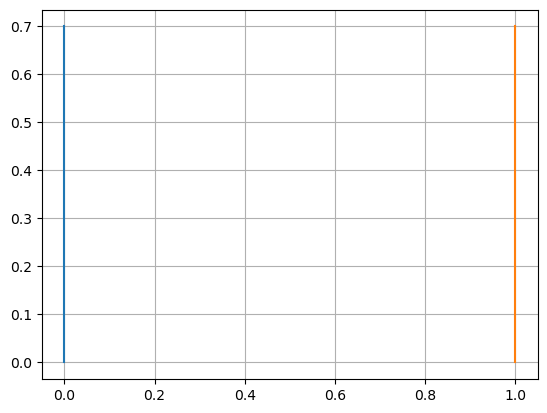

In [5]:
import matplotlib.pyplot as plt
import numpy as np

y = [0, 0.1, 0.2, 0.3, 0.5, 0.7]
y = np.array(y)
x = np.zeros_like(y)
x2 = x + 1
y2 = [0, 0.3, 0.4, 0.45, 0.5, 0.7]

plt.plot(x, y)
# plt.grid()
# plt.show()
plt.plot(x2, y2)
plt.grid()
plt.show()


In [2]:
errorXList = [[0],[0],[0],[0]]
print(errorXList[0][-1]*0.5)

0.0
